# Evolution in music through the years

This notebook contains all information about our data processing steps.  

These include data analysis, cleaning, processing, engineering and visualisation.  
For the intermediate milestone we will also provide an updated plan.  

*Due to problem with the cluster only the subset of the data set was analysed locally*  

### Also note that we were a group of 3 students, and that one of the student decided to drop the course the week end of the 25, this can be taken into account for this milestone. Therefore we reduce the scale of our research questions ( by removing 2 of them due to time constraints and not available data on the cluster)

In [247]:
%matplotlib inline

# Provided library to access hdf5 files from MillionSong dataset
import getters as hdf5_getters

# python internal packages
import os
import glob
import re
import time
import math

# default imports
import numpy as np
import pandas as pd
from pandas import Series, DataFrame, Panel
# plotting libs
import matplotlib.pyplot as plt
import seaborn as sns

# library tested for additional data
#import spotify

# genre simplification
import json
import urllib.request

from sklearn.utils import resample
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier

## Data Fetching 

In [2]:
# Paths for local subset
#local_path = 'C:/Users/M4X/Documents/Uni/EPFL/ADA/ADA/project/data'
local_path = 'C:/Users\Max-Pc/Downloads/millionsongsubset_full/MillionSongSubset/data'

In [3]:
def get_all_interesting_data(basedir,ext='.h5') :
    """
    Creates a two dimensional array containing all songs and features we want to extract from the dataset
    """
    datas = []
    iteration = 0
    for root, dirs, files in os.walk(basedir):
        files = glob.glob(os.path.join(root,'*'+ext))
        for f in files:
            oneSongData = []
            h5 = hdf5_getters.open_h5_file_read(f)
            
            # Columns wich we want to analyse 
            oneSongData.append( hdf5_getters.get_artist_id(h5))
            oneSongData.append(hdf5_getters.get_artist_name(h5))
            oneSongData.append(hdf5_getters.get_year(h5))
            oneSongData.append(hdf5_getters.get_song_id(h5))
            oneSongData.append(hdf5_getters.get_danceability(h5))
            oneSongData.append(hdf5_getters.get_duration(h5))
            oneSongData.append(hdf5_getters.get_song_hotttnesss(h5))
            oneSongData.append(hdf5_getters.get_title(h5))
            oneSongData.append(hdf5_getters.get_tempo(h5))
            oneSongData.append(hdf5_getters.get_time_signature(h5))
            oneSongData.append(hdf5_getters.get_time_signature_confidence(h5))
            oneSongData.append(hdf5_getters.get_artist_mbtags(h5))
            oneSongData.append(hdf5_getters.get_artist_terms(h5))
            oneSongData.append(hdf5_getters.get_artist_location(h5))
            oneSongData.append(hdf5_getters.get_artist_latitude(h5))
            oneSongData.append(hdf5_getters.get_artist_longitude(h5))
            oneSongData.append(hdf5_getters.get_key(h5))
            oneSongData.append(hdf5_getters.get_key_confidence(h5))
            oneSongData.append(hdf5_getters.get_energy(h5))
            oneSongData.append(hdf5_getters.get_loudness(h5))
            oneSongData.append(hdf5_getters.get_artist_hotttnesss(h5))
            
            h5.close()
            
            # Print progress
            iteration+=1
            if(iteration%1000== 0):
                print(iteration)
                
            datas.append(oneSongData)
    return datas

In [4]:
datas = get_all_interesting_data(local_path)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [79]:
# create data frame with all required details
df = pd.DataFrame(datas,columns=['ArtistID','ArtistName','SongYear','SongID','SongDanceability','Duration','SongHotness',\
                                 'SongTitle','SongTempo','SongTimeSignature','SongTimeSignatureConfidence','ArtistMbtags',\
                                 'ArtistTerms','ArtistLocation','ArtistLatitude','ArtistLongitude',\
                                 'SongKey', 'SongKeyConfidence', 'SongEnergy', 'SongLoudness','ArtistHotness'])

## Data Analysis and Cleaing

Since we want to analyze music evolution over time, we cannot use Songs without specified year. They are then dropped.

In [80]:
print("Dropping {} rows.".format(df[df['SongYear'] == 0].shape[0]))
df = df[df['SongYear']>0]

Dropping 5320 rows.


In [81]:
df.head()

,ArtistID,ArtistName,SongYear,SongID,SongDanceability,Duration,SongHotness,SongTitle,SongTempo,SongTimeSignature,...,ArtistMbtags,ArtistTerms,ArtistLocation,ArtistLatitude,ArtistLongitude,SongKey,SongKeyConfidence,SongEnergy,SongLoudness,ArtistHotness
1,b'ARMJAGH1187FB546F3',b'The Box Tops',1969,b'SOCIWDW12A8C13D406',0.0,148.03546,NaN,b'Soul Deep',121.274,4,...,[b'classic pop and rock'],"[b'blue-eyed soul', b'pop rock', b'blues-rock'...","b'Memphis, TN'",35.14968,-90.04892,6,0.169,0.0,-9.843,0.417500
3,b'AR7G5I41187FB4CE6C',b'Adam Ant',1982,b'SONHOTT12A8C13493C',0.0,233.40363,NaN,b'Something Girls',119.293,4,...,"[b'uk', b'british', b'english']","[b'pop rock', b'new wave', b'dance rock', b'ro...","b'London, England'",NaN,NaN,0,0.751,0.0,-9.013,0.454231
4,b'ARXR32B1187FB57099',b'Gob',2007,b'SOFSOCN12A8C143F5D',0.0,209.60608,0.604501,b'Face the Ashes',129.738,4,...,[],"[b'pop punk', b'ska punk', b'breakcore', b'alt...",b'',NaN,NaN,2,0.092,0.0,-4.501,0.401724
8,b'AR8ZCNI1187B9A069B',b'Planet P Project',1984,b'SOIAZJW12AB01853F1',0.0,269.81832,0.265861,b'Pink World',86.643,4,...,[],"[b'new wave', b'progressive rock', b'space roc...",b'',NaN,NaN,4,0.717,0.0,-13.496,0.332276
14,b'ARIK43K1187B9AE54C',b'Lionel Richie',1986,b'SOBONFF12A6D4F84D8',0.0,307.38240,NaN,b'Tonight Will Be Alright',125.197,3,...,[b'soul and reggae'],"[b'quiet storm', b'soft rock', b'pop', b'urban...","b'Beverly Hills, CA'",NaN,NaN,3,0.524,0.0,-8.346,0.553072


In [82]:
# Create an additional data frame which improves machine learning algorithms
normalized_df = df.copy()

In [83]:
df.isnull().sum()

ArtistID                          0
ArtistName                        0
SongYear                          0
SongID                            0
SongDanceability                  0
Duration                          0
SongHotness                    1616
SongTitle                         0
SongTempo                         0
SongTimeSignature                 0
SongTimeSignatureConfidence       0
ArtistMbtags                      0
ArtistTerms                       0
ArtistLocation                    0
ArtistLatitude                 2855
ArtistLongitude                2855
SongKey                           0
SongKeyConfidence                 0
SongEnergy                        0
SongLoudness                      0
ArtistHotness                     0
dtype: int64

We notice, that 1616/4680 Songs do not have a defined Hotness.  
Furthermore, the Latitude and Longitude of the arists for 2855 Songs is not defined.  
For now we will keep the features and rows with NAN, and we will remove them if it would be neccessary to take the NANs into account.  
Let's have a deeper look at the different columns:

In [84]:
with pd.option_context('mode.use_inf_as_null', True):
    print (df.isnull().sum())

ArtistID                          0
ArtistName                        0
SongYear                          0
SongID                            0
SongDanceability                  0
Duration                          0
SongHotness                    1616
SongTitle                         0
SongTempo                         0
SongTimeSignature                 0
SongTimeSignatureConfidence       0
ArtistMbtags                      0
ArtistTerms                       0
ArtistLocation                    0
ArtistLatitude                 2855
ArtistLongitude                2855
SongKey                           0
SongKeyConfidence                 0
SongEnergy                        0
SongLoudness                      0
ArtistHotness                     0
dtype: int64


No features contain infinite values.

In [85]:
df.describe()

C:\Users\Max-Pc\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,SongYear,SongDanceability,Duration,SongHotness,SongTempo,SongTimeSignature,SongTimeSignatureConfidence,ArtistLatitude,ArtistLongitude,SongKey,SongKeyConfidence,SongEnergy,SongLoudness,ArtistHotness
count,4680.000000,4680.0,4680.000000,3064.000000,4680.000000,4680.000000,4680.000000,1825.000000,1825.000000,4680.000000,4680.000000,4680.0,4680.000000,4680.000000
mean,1997.232051,0.0,238.781146,0.444377,125.163716,3.586111,0.510216,37.501760,-61.772744,5.272222,0.451835,0.0,-9.683453,0.441711
std,11.686691,0.0,101.345438,0.222470,35.272251,1.240247,0.375063,16.273911,51.525675,3.547714,0.275340,0.0,5.135927,0.128043
min,1926.000000,0.0,1.044440,0.000000,0.000000,0.000000,0.000000,-41.280540,-155.434140,0.000000,0.000000,0.0,-51.643000,0.000000
25%,1993.000000,0.0,181.152200,NaN,98.698500,3.000000,0.089000,NaN,NaN,2.000000,0.225750,0.0,-12.163000,0.366820
50%,2001.000000,0.0,227.382400,NaN,122.226500,4.000000,0.553000,NaN,NaN,5.000000,0.472000,0.0,-8.588500,0.420938
75%,2006.000000,0.0,278.406080,NaN,146.572000,4.000000,0.868000,NaN,NaN,8.000000,0.661000,0.0,-5.984500,0.511054
max,2010.000000,0.0,1598.197100,1.000000,258.677000,7.000000,1.000000,69.651020,174.767140,11.000000,1.000000,0.0,0.566000,1.082503


By analysing the descriptive statistics of each columns we gained the following insights:

|         |        ArtistID       | ArtistName         |         SongYear        | SongDanceability |       Duration      |   SongHotness   | SongTitle |  SongTempo |    SongTimeSignature   |      SongTimeSignatureConfidence      |                 ArtistMbtags                |                      ArtistTerms                     | ArtistLocation |  ArtistLatitude  |  ArtistLongitude  | SongKey                                                                  | SongKeyConfidence                    | SongEnergy | SongLoudness |   ArtistHotness
|:-------:|:---------------------:|--------------------|:-----------------------:|:----------------:|:-------------------:|:---------------:|:---------:|:----------:|:----------------------:|:-------------------------------------:|:-------------------------------------------:|:----------------------------------------------------:|:--------------:|:----------------:|:-----------------:|--------------------------------------------------------------------------|--------------------------------------|------------|--------------|--------------|
|  format |         string        |       string       |           int           |       float      |        float        |      float      |   string  |    float   |           int          |                 float                 |                    string                   |                        string                        |     string     |       float      |       float       |                                    int                                   |                 float                |    float   |     float    |     float  |
|   type  |       categorial      |     categorial     |        continious       |    continious    |      continious     |    continious   |     -     | continious |         Ordinal        |               continious              |                                             |                                                      |                |    continious    |     continious    |                                  Ordinal                                 |              continious              |            |   continous  |      continous       |
| comment | identifier for artist | name of the Artist | years from 1926 to 2010 |     always 0     | duration in seconds | between 0 and 1 |           |            | values between 0 and 7 | between 0 and 1, 1 is very confident  | comma seperated array with mbtags of artist | comma seperated array with echo nest terms of artist |   town, state  | default latitude | default longitude | 0-11 for [c, c-sharp, d, e-flat, e, f, f-sharp, g, a-flat, a, b-flat, b] | between 0 and 1, 1 is very confident | always 0   |  -51 to 0.5  |  between 0 and 1 

Now that we know a little bit more about the different features, let's have a deeper look at their distribution.

### Song Year

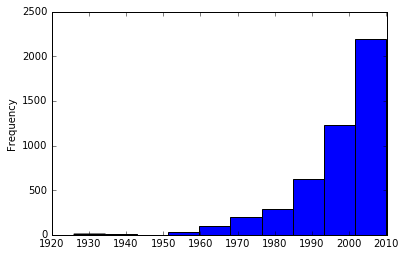

In [86]:
df.SongYear.plot(kind='hist')

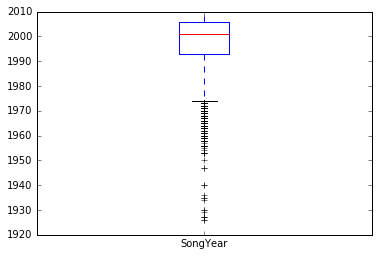

In [87]:
df.SongYear.plot.box()

The distribution of the year feature is negatively skewed.  
The available years span from 1926 to 2010.  
It makes sense to normalize the feature with scaling.
Normalize the year first

In [88]:
normalized_df["SongYearNorm"] = (df.SongYear-df.SongYear.min())/ \
                            (df.SongYear.max()-df.SongYear.min())
normalized_df.head()

,ArtistID,ArtistName,SongYear,SongID,SongDanceability,Duration,SongHotness,SongTitle,SongTempo,SongTimeSignature,...,ArtistTerms,ArtistLocation,ArtistLatitude,ArtistLongitude,SongKey,SongKeyConfidence,SongEnergy,SongLoudness,ArtistHotness,SongYearNorm
1,b'ARMJAGH1187FB546F3',b'The Box Tops',1969,b'SOCIWDW12A8C13D406',0.0,148.03546,NaN,b'Soul Deep',121.274,4,...,"[b'blue-eyed soul', b'pop rock', b'blues-rock'...","b'Memphis, TN'",35.14968,-90.04892,6,0.169,0.0,-9.843,0.417500,0.511905
3,b'AR7G5I41187FB4CE6C',b'Adam Ant',1982,b'SONHOTT12A8C13493C',0.0,233.40363,NaN,b'Something Girls',119.293,4,...,"[b'pop rock', b'new wave', b'dance rock', b'ro...","b'London, England'",NaN,NaN,0,0.751,0.0,-9.013,0.454231,0.666667
4,b'ARXR32B1187FB57099',b'Gob',2007,b'SOFSOCN12A8C143F5D',0.0,209.60608,0.604501,b'Face the Ashes',129.738,4,...,"[b'pop punk', b'ska punk', b'breakcore', b'alt...",b'',NaN,NaN,2,0.092,0.0,-4.501,0.401724,0.964286
8,b'AR8ZCNI1187B9A069B',b'Planet P Project',1984,b'SOIAZJW12AB01853F1',0.0,269.81832,0.265861,b'Pink World',86.643,4,...,"[b'new wave', b'progressive rock', b'space roc...",b'',NaN,NaN,4,0.717,0.0,-13.496,0.332276,0.690476
14,b'ARIK43K1187B9AE54C',b'Lionel Richie',1986,b'SOBONFF12A6D4F84D8',0.0,307.38240,NaN,b'Tonight Will Be Alright',125.197,3,...,"[b'quiet storm', b'soft rock', b'pop', b'urban...","b'Beverly Hills, CA'",NaN,NaN,3,0.524,0.0,-8.346,0.553072,0.714286


### Song Danceability

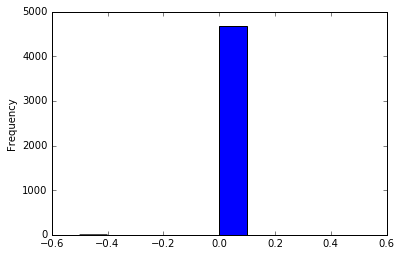

In [89]:
df.SongDanceability.plot(kind='hist')

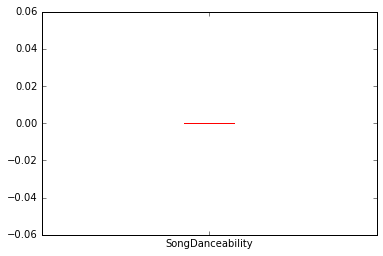

In [90]:
df.SongDanceability.plot.box()

All songs of our cleaned data frame has danceability `0`.  
Therefore we will drop this column.  

In [91]:
normalized_df.drop(labels=['SongDanceability'], axis=1, inplace=True)

### Duration

(35, 21)
(73, 21)


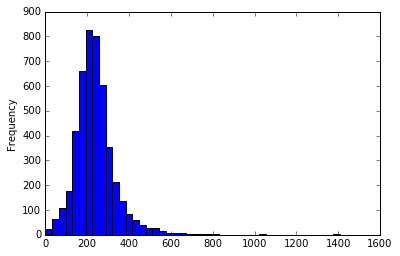

In [92]:
df.Duration.plot(kind='hist',bins=50)
print(df[df['Duration']>600].shape)
print(df[df['Duration']<60].shape)

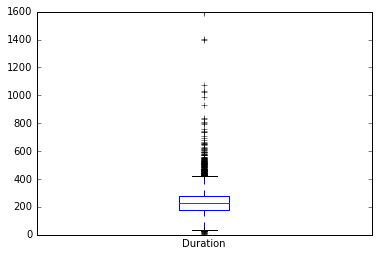

In [93]:
df.Duration.plot.box()

We can see in the histogram, that most of the songs duration are normal distributed.  
However, there are outliers with song durations over 10 minutes and under 60 seconds.   
In our normalized DataFrame we remove the outliers for the duration, since they might deviate too much from the average songs, which we want to analyse.

In [94]:
normalized_df = normalized_df[normalized_df['Duration']>60]
normalized_df = normalized_df[normalized_df['Duration']<600]

### Song Hotness

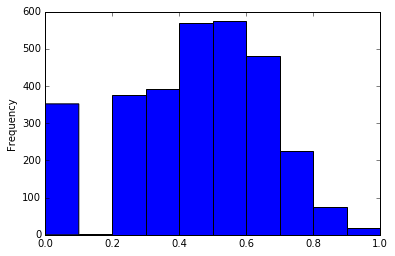

In [95]:
df.SongHotness.plot(kind='hist')

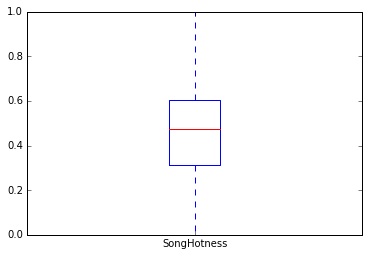

In [96]:
df.SongHotness.plot.box()

The distribution of the Hotness is not skewed.  
There are a few songs where the hotness is missing.  
When analysing hotness remove songs with hotness of zero. But for now we will keep the songs for other analysis tasks.

### Song Tempo 

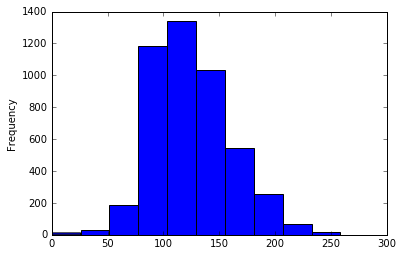

In [97]:
df.SongTempo.plot(kind='hist')

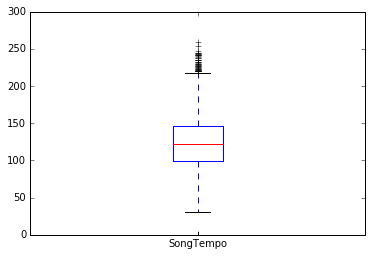

In [98]:
df.SongTempo.plot.box()

The distribution of the tempo is normal. There are some outliers with a very high or low tempo of more than 200 or less than 25.  
We will remove these outliers, since they might deviate from the average songs we want to analyse.

In [99]:
normalized_df = normalized_df[normalized_df['SongTempo']<220]
normalized_df = normalized_df[normalized_df['SongTempo']>25]

### Song Time Signature

The Song Time Signature describes the number of beats per bar.

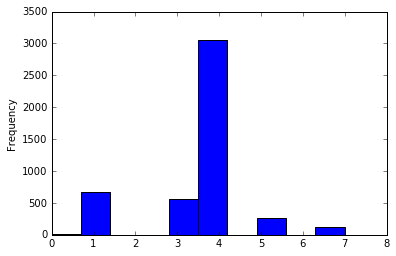

In [100]:
df.SongTimeSignature.plot(kind='hist')

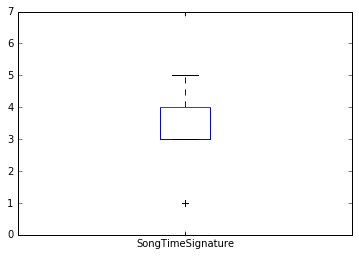

In [101]:
df.SongTimeSignature.plot.box()

The distribution of the Time signature also looks normally distributed, without many outliers.  
Therefore we will keep the feature as it is.

### Song Time Signature Confidence

The Song Time Signature Confidence describes the confidence in the Song Time Signature. It is 1 when the Song Time Signature is very accurate and 0 if is unknown.

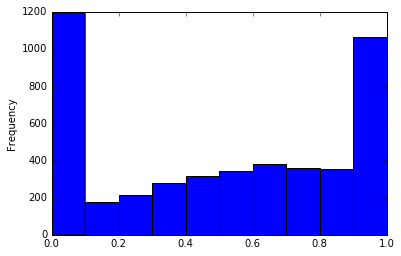

In [102]:
df.SongTimeSignatureConfidence.plot(kind='hist')

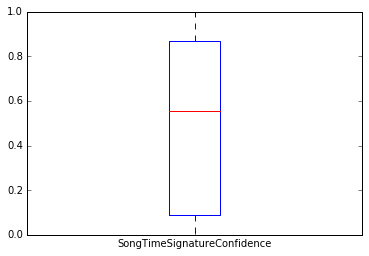

In [103]:
df.SongTimeSignatureConfidence.plot.box()

The majority of songs has either 0 or 1 as confidence. The other confidences are almost equally distributed.    
When analysing TimeSignature we will remove songs with low confidence, but keep the songs for now.

### Artist Location

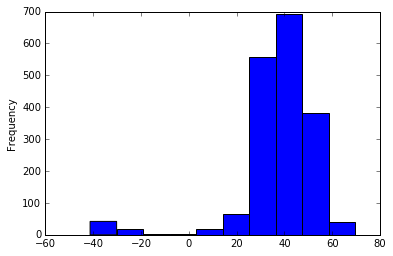

In [104]:
df.ArtistLatitude.plot(kind='hist')

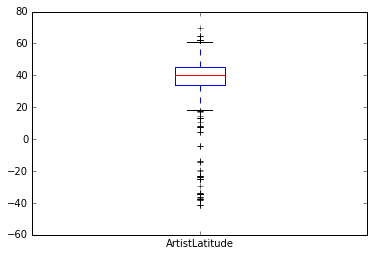

In [105]:
df.ArtistLatitude.plot.box()

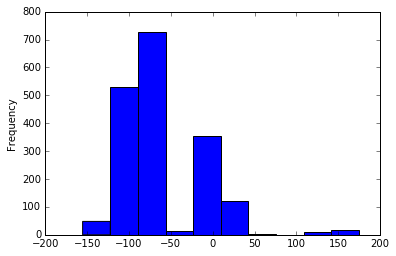

In [106]:
df.ArtistLongitude.plot(kind='hist')

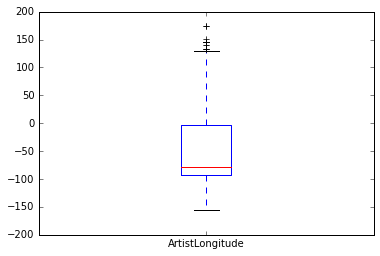

In [107]:
df.ArtistLongitude.plot.box()

We will keep the artist locations for now as they are, since we wanted to look at the correlation between different song types and artist locations.

### Song Key

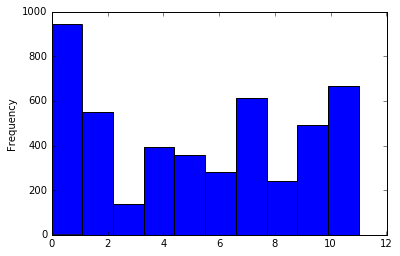

In [108]:
df.SongKey.plot(kind='hist')

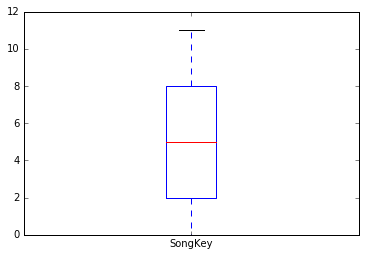

In [109]:
df.SongKey.plot.box()

The key feature has no clear distribution. It contains several peaks which might come from several joined normal distributions for each genre.  
The distribution will be reanalysed for each genre.

### Song Key Confidence

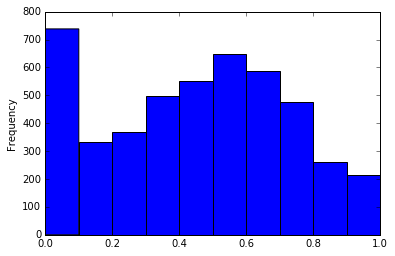

In [110]:
df.SongKeyConfidence.plot(kind='hist')

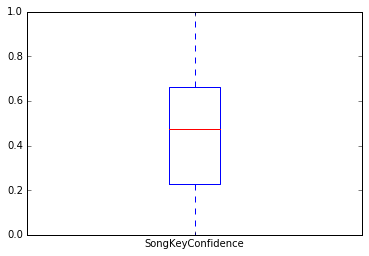

In [111]:
df.SongKeyConfidence.plot.box()

The Song Key Confidence describes the confidence in the Song Key. It is 1 when the Song Key is very accurate and 0 if is unknown.  
The confidence level is not too low, when analysing the key we will remove the songs with low confidence.

### Song Energy

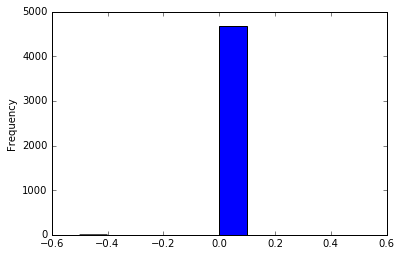

In [112]:
df.SongEnergy.plot(kind='hist')

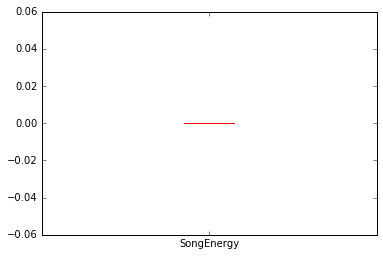

In [113]:
df.SongEnergy.plot.box()

All songs of our cleaned data frame has energy `0`.  
Therefore we will drop this column.  

In [114]:
normalized_df.drop(labels=['SongEnergy'], axis=1, inplace=True)

### Song Loudness

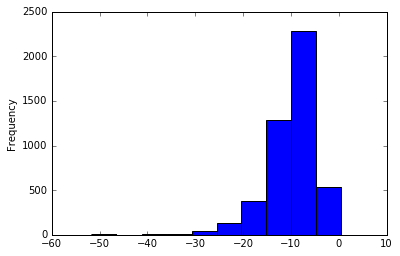

In [115]:
df.SongLoudness.plot(kind='hist')

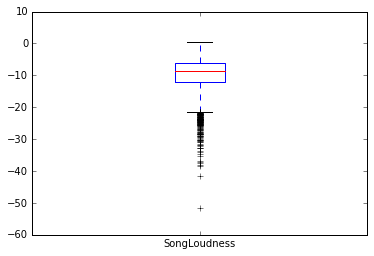

In [116]:
df.SongLoudness.plot.box()

We notice that the loudness is negatively skewed. This means there are a few songs which are really silent.  
We will remove those songs since they deviate from the average song, which we want to analyse.

In [117]:
normalized_df = normalized_df[normalized_df['SongLoudness']>-35]

### Artist Hotness

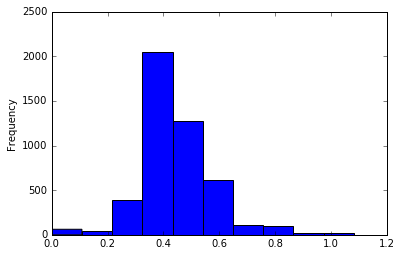

In [118]:
df.ArtistHotness.plot(kind='hist')

We notice that the hotness is also gaussian, with a bigger weight on the right side ( which is nice for us ), and very few datas on the left side.

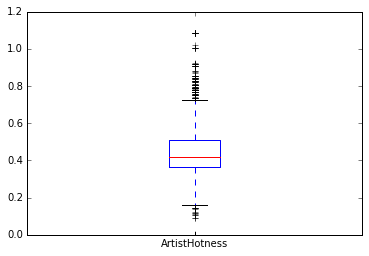

In [119]:
df.ArtistHotness.plot.box()

We will keep this hotness that can be rerally useful for our analysis coupled to other data or to help the clustering of song

## Feature Processing

Beside the numeric features, the data frame also contains features with strings.
Actually all String are bytes string so we will transform them into `str` for better comparison. The concerned features are ArtistName, ArtistLocation, SongTitle, ArtistID and tag from the arrays.

In [120]:
def transform(x):
    if('numpy.nd' in str(type(x))):
        result = []
        for a in x:
            result.append(a.decode(encoding='utf-8'))
        return np.array(result)
    elif(x is not None): 
        return x.decode(encoding="utf-8")


In [121]:
normalized_df.ArtistID = df.ArtistID.apply(lambda row: transform(row))
normalized_df.ArtistLocation = df.ArtistLocation.apply(lambda row : transform(row))
normalized_df.ArtistName= df.ArtistName.apply(lambda row : transform(row))
normalized_df.SongTitle = df.SongTitle.apply(lambda row : transform(row))
normalized_df.ArtistMbtags = df.ArtistMbtags.apply(lambda row : transform(row))
normalized_df.ArtistTerms = df.ArtistTerms.apply(lambda row : transform(row))
normalized_df.head()

,ArtistID,ArtistName,SongYear,SongID,Duration,SongHotness,SongTitle,SongTempo,SongTimeSignature,SongTimeSignatureConfidence,ArtistMbtags,ArtistTerms,ArtistLocation,ArtistLatitude,ArtistLongitude,SongKey,SongKeyConfidence,SongLoudness,ArtistHotness,SongYearNorm
1,ARMJAGH1187FB546F3,The Box Tops,1969,b'SOCIWDW12A8C13D406',148.03546,NaN,Soul Deep,121.274,4,0.384,[classic pop and rock],"[blue-eyed soul, pop rock, blues-rock, beach m...","Memphis, TN",35.14968,-90.04892,6,0.169,-9.843,0.417500,0.511905
3,AR7G5I41187FB4CE6C,Adam Ant,1982,b'SONHOTT12A8C13493C',233.40363,NaN,Something Girls,119.293,4,0.000,"[uk, british, english]","[pop rock, new wave, dance rock, rock, new rom...","London, England",NaN,NaN,0,0.751,-9.013,0.454231,0.666667
4,ARXR32B1187FB57099,Gob,2007,b'SOFSOCN12A8C143F5D',209.60608,0.604501,Face the Ashes,129.738,4,0.562,[],"[pop punk, ska punk, breakcore, alternative me...",,NaN,NaN,2,0.092,-4.501,0.401724,0.964286
8,AR8ZCNI1187B9A069B,Planet P Project,1984,b'SOIAZJW12AB01853F1',269.81832,0.265861,Pink World,86.643,4,0.487,[],"[new wave, progressive rock, space rock, eurod...",,NaN,NaN,4,0.717,-13.496,0.332276,0.690476
14,ARIK43K1187B9AE54C,Lionel Richie,1986,b'SOBONFF12A6D4F84D8',307.38240,NaN,Tonight Will Be Alright,125.197,3,0.211,[soul and reggae],"[quiet storm, soft rock, pop, urban, adult con...","Beverly Hills, CA",NaN,NaN,3,0.524,-8.346,0.553072,0.714286


## Data Correlation

For the correlation we will focus on the rows with a high confidence measure.

In [122]:
corr_df = normalized_df.copy()
corr_df = corr_df[normalized_df['SongTimeSignatureConfidence']>0.5]
corr_df = corr_df[normalized_df['SongKeyConfidence']>0.5]

C:\Users\Max-Pc\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


In [123]:
corr = corr_df.corr()
corr

,SongYear,Duration,SongHotness,SongTempo,SongTimeSignature,SongTimeSignatureConfidence,ArtistLatitude,ArtistLongitude,SongKey,SongKeyConfidence,SongLoudness,ArtistHotness,SongYearNorm
SongYear,1.000000,0.123693,0.121156,0.061124,0.045342,0.005752,-0.011298,0.061663,0.014605,-0.038174,0.354848,0.110084,1.000000
Duration,0.123693,1.000000,-0.011613,-0.008254,0.013285,0.010330,0.050131,0.063102,0.002657,0.041513,0.069551,0.025149,0.123693
SongHotness,0.121156,-0.011613,1.000000,0.062046,0.039497,0.037246,0.007138,-0.088808,0.036861,-0.096620,0.227774,0.518601,0.121156
SongTempo,0.061124,-0.008254,0.062046,1.000000,0.022386,-0.066615,-0.006675,-0.038345,-0.021538,0.024720,0.074821,0.054544,0.061124
SongTimeSignature,0.045342,0.013285,0.039497,0.022386,1.000000,-0.016657,0.056957,0.073780,-0.019761,-0.074196,0.026566,-0.003841,0.045342
SongTimeSignatureConfidence,0.005752,0.010330,0.037246,-0.066615,-0.016657,1.000000,-0.011536,-0.008529,-0.000935,-0.005282,-0.001258,0.030779,0.005752
ArtistLatitude,-0.011298,0.050131,0.007138,-0.006675,0.056957,-0.011536,1.000000,0.096827,-0.019033,0.018063,0.046805,-0.058398,-0.011298
ArtistLongitude,0.061663,0.063102,-0.088808,-0.038345,0.073780,-0.008529,0.096827,1.000000,-0.020110,0.000756,-0.063922,-0.068398,0.061663
SongKey,0.014605,0.002657,0.036861,-0.021538,-0.019761,-0.000935,-0.019033,-0.020110,1.000000,-0.099049,0.026447,0.082629,0.014605
SongKeyConfidence,-0.038174,0.041513,-0.096620,0.024720,-0.074196,-0.005282,0.018063,0.000756,-0.099049,1.000000,-0.107177,-0.081807,-0.038174


We seem to have very few correlated features, so we will try to analyze by doing some more analysis on different paramters and doing some feature engineering.  

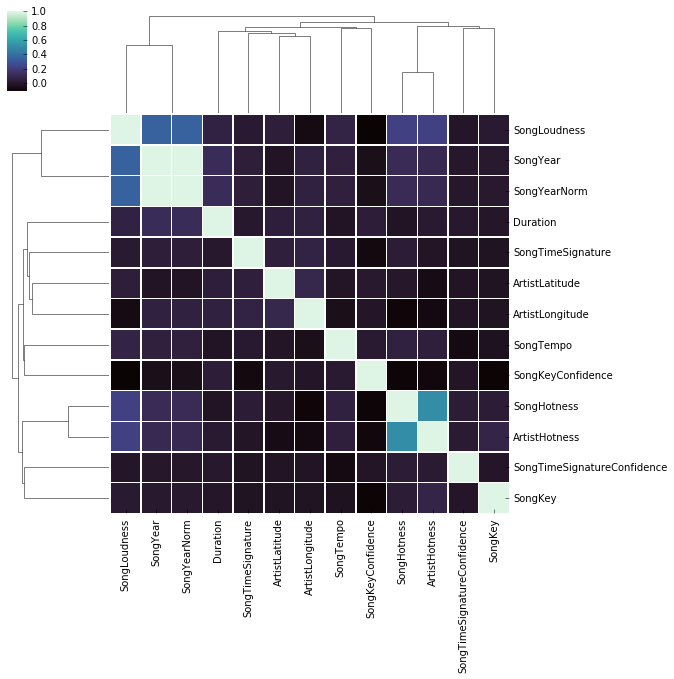

In [124]:
cg = sns.clustermap(corr, linewidth=.5, figsize=(9,9),cmap='mako')
plt.setp(cg)

The most correlated features are SongYear and SongLoudness, SongHotness and SongLoudness, and SongHotness and SongYear.  
The correlation between Hotness and Year exists, since the hotness value is only a snapshot of the hotness in 2010.  
But there seems to be a trend for Loudness over the years, correlated with Hotness for Song and artist

## Further dependencies

### Preprocessing

Since we want to analyse the change over time and the time feature is very unbalanced, we will resample our data to a equally distributed time feature.

In [51]:
def resample_df(df):

    classes = [0,1950,1960,1970,1980,1990,2000,2010,2015]
    df_classes = [] # df containing the rows of each class
    for i in range(1,len(classes)-1):
        df_classes.append(df[np.logical_and(df.SongYear > classes[i-1], \
                                     df.SongYear < classes[i+1])])

    # print shapes for overview
    for i in range(len(df_classes)):
        print (df_classes[i].shape)

    # resample dataframes with replacement in order to aquire the same number of tracks per class
    for i in range(len(df_classes)-1):
        df_classes[i] = resample(df_classes[i], replace=True, n_samples=2326, random_state=42)

    # merge the data frames
    resampled_df = df_classes[0]
    for i in range(1,len(df_classes)):
        resampled_df = pd.concat([resampled_df, df_classes[i]])
    return resampled_df

In [52]:
resampled_df = resample_df(normalized_df)


(46, 20)
(163, 20)
(365, 20)
(647, 20)
(1559, 20)
(3532, 20)
(2326, 20)


Let's see if we can find correlations which can e.g. not be found by the pearson coefficient:

### Correlation for Song Year

In [53]:
def print_time_statistics(df):
    x = df.SongYear
    y = df.SongHotness
    xmin = x.min()
    xmax = x.max()
    ymin = y.min()
    ymax = y.max()

    fig, ax = plt.subplots()
    hb = ax.hexbin(x, y, gridsize=15, cmap="YlGn")
    ax.axis([xmin, xmax, ymin - 0.1, ymax + 0.1])
    ax.set_title("Hexagon binning Year, Song Hotness")
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('counts')

    plt.show()

    x = df.SongYear
    y = df.ArtistHotness
    xmin = x.min()
    xmax = x.max()
    ymin = y.min()
    ymax = y.max()

    fig, ax = plt.subplots()
    hb = ax.hexbin(x, y, gridsize=25, cmap="YlGn")
    ax.axis([xmin, xmax, ymin - 0.01, ymax + 0.01])
    ax.set_title("Hexagon binning Year, Artist Hotness")
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('counts')

    plt.show()

    x = df.SongYear
    y = df.Duration
    xmin = x.min()
    xmax = x.max()
    ymin = y.min()
    ymax = y.max()

    fig, ax = plt.subplots()
    hb = ax.hexbin(x, y, gridsize=15, cmap="YlGn")
    ax.axis([xmin, xmax, ymin - 0.1, ymax + 0.1])
    ax.set_title("Hexagon binning Year, Duration")
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('counts')

    plt.show()

    x = df.SongYear
    y = df.SongLoudness
    xmin = x.min()
    xmax = x.max()
    ymin = y.min()
    ymax = y.max()

    fig, ax = plt.subplots()
    hb = ax.hexbin(x, y, gridsize=15, cmap="YlGn")
    ax.axis([xmin, xmax, ymin - 0.1, ymax + 0.1])
    ax.set_title("Hexagon binning Year, Loudness")
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('counts')

    plt.show()

    x = df.SongYear
    y = df.Duration
    xmin = x.min()
    xmax = x.max()
    ymin = y.min()
    ymax = y.max()

    fig, ax = plt.subplots()
    hb = ax.hexbin(x, y, gridsize=15, cmap="YlGn")
    ax.axis([xmin, xmax, ymin - 0.1, ymax + 0.1])
    ax.set_title("Hexagon binning Year, Duration")
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('counts')

    plt.show()

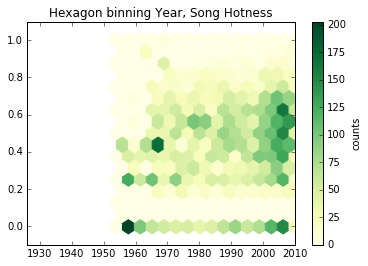

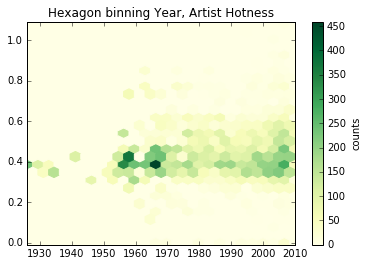

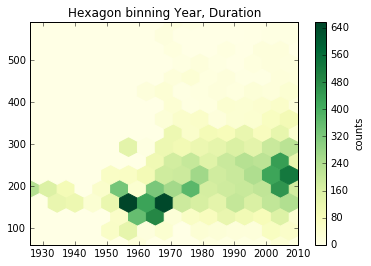

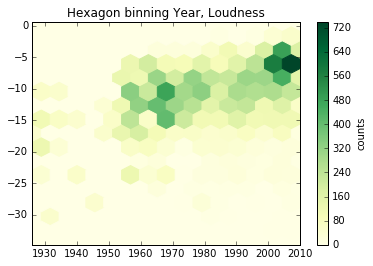

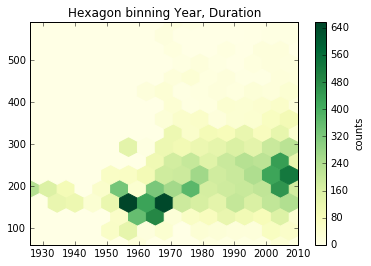

In [54]:
print_time_statistics(resampled_df)

We can indeed see that the majority of the song we have  with a hotness > 0 are song from the 2000's, and there is a general evolution through our data, old song have few hotness > 0, and the more we go to 2010, the more song we have with a hotness >0

For artist hotness, it is actually different, we have almost no artist that have a 0 hotness, and artist in the 200s have a lot of hotness, but we seems to have more artist that released song from 1990-2000s. This might be a problem due to the distribution of artist from song. An artist might have lot of song released in different period (around 5-6 years)

The evolution of duration has not change this much, the duration seems to be quite similar through the years

### Interest about Artist and released Songs

Here there is an interesting correlation between years and loudness, it seems that song from nowadays are louder than the one from 20 or 30 years ago

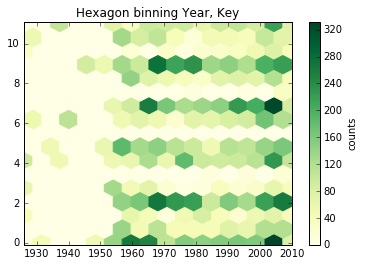

In [55]:
x = resampled_df.SongYear
y = resampled_df.SongKey
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()

fig, ax = plt.subplots()
hb = ax.hexbin(x, y, gridsize=15, cmap="YlGn")
ax.axis([xmin, xmax, ymin - 0.1, ymax + 0.1])
ax.set_title("Hexagon binning Year, Key")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')

plt.show()

In [56]:
def inSet(setC,x):
    """
    Appends x to the set of it is not yet included
    """
    if(x not in setC):
        setC.append(x)

In [57]:
distinctName = []
# create set for artists
normalized_df.ArtistName.apply(lambda x : inSet(distinctName,x))
print (len(distinctName))

# Create data frame for artists
artistDF = pd.DataFrame(distinctName,columns=['ArtistName'])
artistDF.head()

2195


,ArtistName
0,The Box Tops
1,Adam Ant
2,Gob
3,Planet P Project
4,Lionel Richie


In [58]:
songNumber = []
songYear = []

# fetch song release years of artist
for x in distinctName:
    test = normalized_df[normalized_df.ArtistName==x]['SongYear']
    songNumber.append(len(test))
    songYear.append(test.values)

# Extend data frame
artistDF['NumberSong']= songNumber
artistDF['SongsYear'] = songYear
artistDF['StdYear'] = artistDF.SongsYear.apply(lambda x : np.std(x))

In [59]:
artistDF.head()

,ArtistName,NumberSong,SongsYear,StdYear
0,The Box Tops,4,"[1969, 1967, 1967, 1968]",0.829156
1,Adam Ant,4,"[1982, 1982, 1982, 1998]",6.928203
2,Gob,2,"[2007, 2001]",3.000000
3,Planet P Project,2,"[1984, 1984]",0.000000
4,Lionel Richie,2,"[1986, 2004]",9.000000


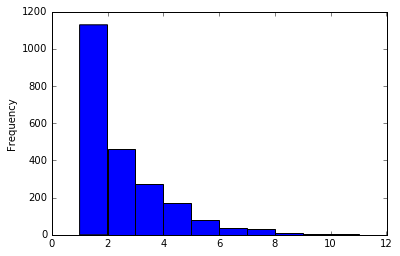

In [60]:
artistDF.NumberSong.plot(kind='hist')

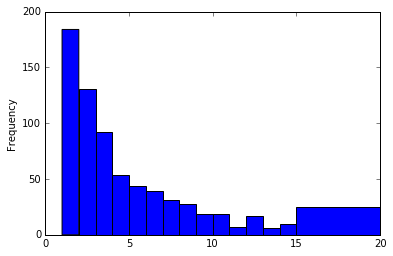

In [61]:
artistDF.StdYear.plot(kind='hist',bins=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20])

We see that the distribution of song from artist is positively skewed. Also some artist have really high standard deviation for song release ( more than 5 years ) which can be interesting for evolution of the same artist, to see if he released a popular song after an already popular one or the contrary what makes the popularity change in 2 of its song

### Other Correlations

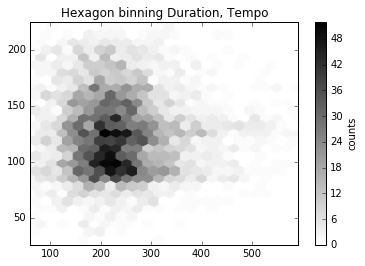

In [62]:
x = normalized_df.Duration
y = normalized_df.SongTempo
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()

fig, ax = plt.subplots()
hb = ax.hexbin(x, y, gridsize=25, cmap="gist_yarg")
ax.axis([xmin, xmax, ymin - 5, ymax + 5])
ax.set_title("Hexagon binning Duration, Tempo")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')

plt.show()

As said previously, the duration and tempo of songs are quite clustered between [120-300] seconds and [90-160] BPM

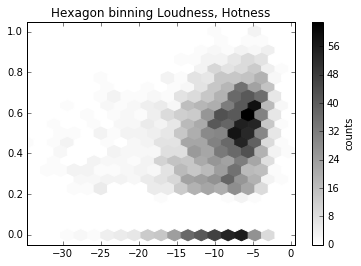

In [63]:
x = normalized_df.SongLoudness
y = normalized_df.SongHotness
xmin = x.min()
xmax = x.max()
ymin = y.min()
ymax = y.max()

fig, ax = plt.subplots()
hb = ax.hexbin(x, y, gridsize=20, cmap="gist_yarg")
ax.axis([xmin, xmax, ymin - 0.05, ymax + 0.05])
ax.set_title("Hexagon binning Loudness, Hotness")
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')

plt.show()

We can see that most of the song are located in range 90-150 in BPM with duration between 120 - 300 seconds.  


We can't do much more correlation analysis as few datas are correlated and we have a small subset so this is likely to change with a full dataset.

In [64]:
df.ArtistTerms.head()

1     [b'blue-eyed soul', b'pop rock', b'blues-rock'...
3     [b'pop rock', b'new wave', b'dance rock', b'ro...
4     [b'pop punk', b'ska punk', b'breakcore', b'alt...
8     [b'new wave', b'progressive rock', b'space roc...
14    [b'quiet storm', b'soft rock', b'pop', b'urban...
Name: ArtistTerms, dtype: object

In [65]:
df.ArtistMbtags.head()

1           [b'classic pop and rock']
3     [b'uk', b'british', b'english']
4                                  []
8                                  []
14               [b'soul and reggae']
Name: ArtistMbtags, dtype: object

Here we can see that the term of MbTags are more generic and some do not have any tags, while the tags from Terms are really variate.  
We will further elaborate the genres in the next chapter.

## Feature Engineering

The amout of different genres is too high. We want to reduce the number of genres.  
Therefore we reduce the genres with an obtained json tree structure from http://musicmap.info/.

In [66]:
"""
Reduce the genres to a main genre using the provided json file
"""
# Main genres
maingenre = ['inl','met','rnr','gld','pwv','hcp','alt','con','pop','cou','rnb','gos','blu','jaz','jam','rap','brb','dnb','hct','tec','hou','tra','dtp']

genreTree = {}
with urllib.request.urlopen('http://musicmap.info/master-genrelist.json') as url:
    data = json.loads(url.read().decode())
    
    # check the first level
    for x in maingenre: 
        name = data.get(x).get('name')
        
        # clean data
        genreName = name.replace('<span class=\'subtitle\'>','')
        genreName = genreName.replace('</span>','')
        genreName = genreName.replace(' \'N\'',' N')
        
        # find genres
        genreNames = re.findall(r'([A-Z]+\s+\'+[A-Z+\'+\s]*|[A-Z+\s+\-]+)',data.get(x).get('name'))
        for g in genreNames:
            if(len(g)>1):
                # add to map
                genreTree[g.replace(' ', '')] = genreName
                
        # check the second level
        for subgenreEntry in data.get(x)["genrelist"]:
            
            # clean data
            subgenres = re.sub(r"<a.*'>", "", subgenreEntry)
            subgenres = re.sub(r'</a>', "", subgenres)
            subgenres = subgenres.replace('&amp','and')
            subgenres = subgenres.replace(' \'N\'',' N')
            
            # find genres
            subgenres = subgenres.split('/')
            for subgenre in subgenres:
                # add to map
                genreTree[subgenre.strip(' ')] = genreName
                
genreTree

{'(AVANT-GARDE) INDUSTRIAL': 'INDUSTRIAL &amp GOTHIC',
 '(DIRTY) SOUTH RAP, CRUNK and SNAP': 'RAP / HIP-HOP MUSIC',
 '(EARLY) GABBER': 'HARDCORE TECHNO',
 '(EARLY) POP ROCK and POWER POP': 'POP MUSIC',
 '(EARLY) RHYTHM N BLUES': 'RHYTHM N BLUES (R&B)',
 '(ELECTRIC) TEXAS BLUES': 'BLUES',
 '(FREE)TEK(K)NO': 'TECHNO',
 '(MERSEY)BEAT': 'GOLDEN AGE / CLASSIC ROCK',
 '(NEGRO) SPIRITUALS & WORKSONGS': 'GOSPEL &amp; PIONEERS',
 '(ROOTS) REGGAE': 'JAMAICAN (MUSIC) / REGGAE',
 '(WEST COAST) GANGSTA RAP': 'RAP / HIP-HOP MUSIC',
 'ACID HOUSE': 'HOUSE',
 'ACID JAZZ': 'JAZZ',
 'ACID ROCK and PSYCHEDELIA': 'GOLDEN AGE / CLASSIC ROCK',
 'ADULT CONTEMPORARY (A.C.)': 'POP MUSIC',
 'AGGREPPO': 'INDUSTRIAL &amp GOTHIC',
 'ALTERNATIVE': 'ALTERNATIVE ROCK / INDIE',
 'ALTERNATIVE COUNTRY': 'COUNTRY',
 'ALTERNATIVE ROCK': 'ALTERNATIVE ROCK / INDIE',
 'AMBIENT': 'DOWNTEMPO / AMBIENT',
 'AMBIENT BREAKS & ILLBIENT': 'DOWNTEMPO / AMBIENT',
 'AMBIENT BREAKS and ILLBIENT': 'BREAKBEAT',
 'AMBIENT DRUM N BASS and JA

Now we can reduce all genres to a few main genres. Let's see how the genres from both data sources match:

In [67]:
# create a dict in order to identify how frequently the genres are used
dicoGenre = {}
for elem in genreTree.keys():
    if(dicoGenre.get(genreTree[elem]) is None):
        dicoGenre[genreTree[elem]]=0

In [68]:
# Check how good the genre dict performs on both genre lists
cnt_hit = 0
cnt_miss = 0
print ("Mbtags")

for songGenres in normalized_df['ArtistMbtags']:
    for genre in songGenres:
        if str(genre).upper() in genreTree.keys():
            cnt_hit += 1
        else:
            cnt_miss += 1

print (cnt_hit)
print (cnt_miss)

cnt_hit = 0
cnt_miss = 0
# performed better, so check number of songs per genre
print ("Echo Nest Terms")

for songGenres in normalized_df['ArtistTerms']:
    for genre in songGenres:
        genre = genre.replace('\'n','n')
        if str(genre).upper() in genreTree.keys():
            # perfect match, add to dict
            mainParentG = genreTree[genre.upper()]
            dicoGenre[mainParentG] += 1
            cnt_hit += 1
        else:
            # search if substring is contained 
            isGood = False
            genreSplit = genre.split(' ')
            for elem in genreSplit:
                if str(elem).upper() in genreTree.keys() and (not str(elem).upper()=='MUSIC'):
                    # substring matched
                    mainParentG = genreTree[elem.upper()]
                    dicoGenre[mainParentG] +=1
                    cnt_hit +=1
                    isGood = True
                    break
            if (not isGood):
                # not substring found
                cnt_miss +=1

print (cnt_hit)
print (cnt_miss)
print (dicoGenre)

Mbtags
2645
7803
Echo Nest Terms
66443
66085
{'CONTEMPORARY ROCK': 9233, 'INDUSTRIAL &amp GOTHIC': 975, 'JAMAICAN (MUSIC) / REGGAE': 2510, 'BLUES': 2978, 'RHYTHM N BLUES (R&B)': 1141, 'RAP / HIP-HOP MUSIC': 1751, 'DOWNTEMPO / AMBIENT': 4223, "DRUM N BASS (D'N'B) / JUNGLE": 383, 'POP MUSIC': 7440, 'HOUSE': 1816, 'COUNTRY': 2933, 'HEAVY METAL': 5689, 'JAZZ': 5094, 'HARDCORE PUNK': 2290, 'ALTERNATIVE ROCK / INDIE': 7498, 'PUNK ROCK / NEW WAVE': 1358, 'BREAKBEAT': 1186, 'TRANCE': 725, 'GOLDEN AGE / CLASSIC ROCK': 3239, 'TECHNO': 825, "ROCK N ROLL (R'N'R)": 1351, 'HARDCORE TECHNO': 1482, 'GOSPEL &amp; PIONEERS': 323}


We have a 50/50 matching for terms, only unknow genre are not hited by the filter that we do not want to analyse.
We can dedcide later if we want to introduce this or another filter but we keep this one for the moment
For the dictionnary it needs some reworks, as we can add a several time the same tag to a song ( if it has rock and pop rock and hard rock tags for example )

## Manipulation on some of the columns

Here we do some feature extraction, features normalization was done before, and some fetching of other datas from other API

First we will create an additional column for the confidence features to process them more easy in the future.

In [69]:
normalized_df['SongTimeWithConfidence'] = df['SongTimeSignature']*df['SongTimeSignatureConfidence']

In [70]:
normalized_df['SongKeyWithConfidence'] = df['SongKey']*df['SongKeyConfidence']

In [71]:
normalized_df.head()

,ArtistID,ArtistName,SongYear,SongID,Duration,SongHotness,SongTitle,SongTempo,SongTimeSignature,SongTimeSignatureConfidence,...,ArtistLocation,ArtistLatitude,ArtistLongitude,SongKey,SongKeyConfidence,SongLoudness,ArtistHotness,SongYearNorm,SongTimeWithConfidence,SongKeyWithConfidence
1,ARMJAGH1187FB546F3,The Box Tops,1969,b'SOCIWDW12A8C13D406',148.03546,NaN,Soul Deep,121.274,4,0.384,...,"Memphis, TN",35.14968,-90.04892,6,0.169,-9.843,0.417500,0.511905,1.536,1.014
3,AR7G5I41187FB4CE6C,Adam Ant,1982,b'SONHOTT12A8C13493C',233.40363,NaN,Something Girls,119.293,4,0.000,...,"London, England",NaN,NaN,0,0.751,-9.013,0.454231,0.666667,0.000,0.000
4,ARXR32B1187FB57099,Gob,2007,b'SOFSOCN12A8C143F5D',209.60608,0.604501,Face the Ashes,129.738,4,0.562,...,,NaN,NaN,2,0.092,-4.501,0.401724,0.964286,2.248,0.184
8,AR8ZCNI1187B9A069B,Planet P Project,1984,b'SOIAZJW12AB01853F1',269.81832,0.265861,Pink World,86.643,4,0.487,...,,NaN,NaN,4,0.717,-13.496,0.332276,0.690476,1.948,2.868
14,ARIK43K1187B9AE54C,Lionel Richie,1986,b'SOBONFF12A6D4F84D8',307.38240,NaN,Tonight Will Be Alright,125.197,3,0.211,...,"Beverly Hills, CA",NaN,NaN,3,0.524,-8.346,0.553072,0.714286,0.633,1.572


## Concerning Spotify API
We tried to get some data from Spotify [Spotify Python API](https://github.com/plamere/spotipy), but due to the time it takes (3 request/s, 1h to fetch what we want for only the subset) we decided not to parse anything from it unfortunately, a portion of code is still described below to see that we actually tried it.

In [72]:
#token = 'BQAu-KsyKpk7NBP-1ZGCNa-RoHNak0ZNAr3l3mi2In0mLy0o71LAl5OycY1h3K5S8INBp0kvic2lgRFESxry3EW4m7PUfFQZp5dAeSLSgpNs25xfNJbs_KJkuTEChlptb8ZtYF2NiGY4'
#sp = spotipy.Spotify(token)

def spotiAPI(name):
    results = sp.search(q=name, limit=1)
    idd = results['tracks']['items'][0]['artists'][0]['id']
    resultArt = sp.artist(idd)
    #time.sleep(0.02)
    print(resultArt['followers']['total'])
    return resultArt['followers']['total']

In [73]:
#normalized_df['ArtistFollower'] = df.ArtistName.apply(lambda x : spotiAPI(x))

## Updated Plan

### Gained Knowledge


We did some manipulation from raw datas, we actually get interesting result. The normalization of the year will help our analysis notably in ML functions.
We were also able to construct another dataframe that treats Artists and not songs, to do stats on artist in addition of songs.
The genre matching is not quite what we wanted for the moment, but we have some results, it can be improved to have a general genre/subgenre matching. We do not want to reduce it too much to avoid merging things that cannot be compared.
We also noticed that few of our features are strongly correlated, **but no real knowledge was acquire because we used 1% of the dataset**


### Methods for the future

** Use cluster and full data set, redo analysis **  

* Which features did change (e.g. bpm, beats)?
To have a general view of how song that are released nowadays change from previous one, if the music has evolved in a good way, bad way (quite personnal feeling though) or even neutral but with positive/negative impact
   * Calculate features aggregated by year, plot time series (with error bars)
   * Can we see a major change of one features over the years?
  
  
* How did genres change (e.g. popularity, features of specific genres, higher variance)?
We can link genre Evolution to time period in 
    * Create data frame for each genre with songs of genre
    * Plot number of songs per year
    * Redo question one for features
    * Plot chart which shows span of features per year
    * Look at subgenres?
  
  
* How did the distribution of music change (e.g. change of number of genres, variance of features)?
Here we can get some interting result with distribution that could be used for the final blog post if rendered well, as our main goal is to look at the evolution of music, so find a way such as colorMap or any structure tat is nice but also quite easy to read to get the results.
    * Plot chart that shows the numer of features per year
    * Plot chart which shows genre distribution (number of songs per genre) over time
  
  
* Train classifier for genre on recent songs.
So to be a little bit more precise, try to classify song with date > 2000, thanks to the features, using a classifier ( K-NN or Random forest still need to decide which it is not binary classification here as there are more than 2 genres) and then try to fit the older songs to see if they would be classified in the correct genre list.
This result can be used to see if the change in music features has a real impact on what genre it could be classified in or even if the genre itself changed ( introduction of new subgenre or even genre apparition --> ex : Dubstep)
    * Apply it to old songs
    * Evaluate the results
  
#### Things we consider but will not implement for the final results are: (only two team members left)
* Which songs from the past are still trending (why)?
* How did song titles (artist names) change over time?
* Where did (which) songs get released at which time (do dependencies exist between similar Songs)?
  
  
Other interesting analysis:
* Run unsupervised clustering
    * compare clusters to genres
* Compare song and artist name with codec by hashing to get Jacardian distance to get similar song artist name and compare with hotness and other parameters. Maybe even cluster the one close to each other to get another clustering way


# From here Things for Milestone 3

Music is a form of art, and a cultural activity that have been practiced since prehistoric time. Nowadays it is everywhere, and seems inseparable from our life-style, as even humming or hitting an object with your finger makes "music".  
The evolution of this field is thus a really intersting subject to study. It is linked to cultural movement in history, such as the 80's with hippies movement for example but also architecture ([Baroque](https://en.wikipedia.org/wiki/Baroque_music)) or religion ([Jean-Sébastien Bach](https://en.wikipedia.org/wiki/Johann_Sebastian_Bach) was indeed doing muisc link to religion). This can help us understand how music evolves with the time with how events and movement influence it, but also how music affects these different things. 

It has also become a big industry, with the apparition of the term "commercial music", and interest more and more people, [for example this video](https://www.youtube.com/watch?v=lExW80sXsHs), that collected more than 100 millions views.  
In this study we will concentrate on music from the 20th century and beginning of 21th century, and we will try to awnser the following questions:
    
   * How did music features change during the last 80 years, in terms of duration, style, or even rythm ?  
    
   * What makes a Song popular a few years ago, what make one popular today, and is the formula for a popular song possible to elaborate ?
   
We will try to awnser these questions as much as possible in the following lines, with keeping in mind that evolution is a neutral term, and also that popularity is quite subjective.

### Create Dataframes for each Genre

#### Without Genre Processing

In [ ]:
def get_songs_genre(genre_column):

    set_genre = set()

    for genres in normalized_df[genre_column]:
        set_genre = set_genre | set(genres)

    print ("Unique terms: {}".format(len(set_genre)))

    # Init dict with songs per genre
    songs_genre = {}
    for genre in set_genre:
        songs_genre[genre] = pd.DataFrame([], columns=['ArtistID','ArtistName','SongYear','SongID','SongDanceability','Duration','SongHotness',\
                                     'SongTitle','SongTempo','SongTimeSignature','SongTimeSignatureConfidence','ArtistMbtags',\
                                     'ArtistTerms','ArtistLocation','ArtistLatitude','ArtistLongitude',\
                                     'SongKey', 'SongKeyConfidence', 'SongEnergy', 'SongLoudness','ArtistHotness'])

    iteration = 0
    for index, song in normalized_df.iterrows():
        if iteration % 1000 == 0:
            print (iteration)
        iteration += 1
        for genre in song[genre_column]:
            songs_genre[genre].loc[index] = song
    return songs_genre

songs_genre_terms = get_songs_genre("ArtistTerms")

In [ ]:
songs_genre_terms_num = { x: set_genre_terms[x].shape[0] for x in songs_genre_terms.keys() }
top_genres = sorted(songs_genre_terms_num, key=songs_genre_terms_num.get, reverse=True)[:5]
top_genres

#### Analyse these Dataframes

In [ ]:
for g in top_genres:
    print (g)
    print_time_statistics(resample_df(songs_genre_terms[g]))

#### With Genre Processing

In [ ]:
def mapper(g):
    g.upper()

In [ ]:
def extract_parent_genres(genres):
    """
    Extracts the parent genres based on an array of genres
    TODO Fix
    """
    genres_parent = set()
    for genre in genres:
        key = mapper(genre)
        if key in genreTree.keys():
            genres_parent = genres_parent | set(genreTree[key])
        else:
            pass
    return genres_parent

In [ ]:
normalized_df["ParentGenres"] = df.ArtistTerms.apply(lambda x : extract_parent_genres(x))

set_genre_parent = get_songs_genre("ParentGenres")
for genre in set_genre_parent:
    print ("Genre {} has {} songs.".format(genre, set_genre_parent[genre].shape[0]))

## Train classifier for genre on recent songs.

#### Drop some of the junk variables (id, song_id, ...)¶

In [425]:
df_knn = normalized_df[normalized_df['SongYear']>2000]
df_knn.head()

,ArtistID,ArtistName,SongYear,SongID,Duration,SongHotness,SongTitle,SongTempo,SongTimeSignature,SongTimeSignatureConfidence,ArtistMbtags,ArtistTerms,ArtistLocation,ArtistLatitude,ArtistLongitude,SongKey,SongKeyConfidence,SongLoudness,ArtistHotness,SongYearNorm
4,ARXR32B1187FB57099,Gob,2007,b'SOFSOCN12A8C143F5D',209.60608,0.604501,Face the Ashes,129.738,4,0.562,[],"[pop punk, ska punk, breakcore, alternative me...",,NaN,NaN,2,0.092,-4.501,0.401724,0.964286
18,ARYKCQI1187FB3B18F,Tesla,2004,b'SOXLBJT12A8C140925',290.29832,0.684136,Caught In A Dream,150.062,4,0.931,[],"[hard rock, heavy metal, blues-rock, classic r...",,NaN,NaN,7,0.725,-5.271,0.513463,0.928571
23,ARMAC4T1187FB3FA4C,The Dillinger Escape Plan,2004,b'SOBBUGU12A8C13E95D',207.77751,0.666528,Setting Fire to Sleeping Giants,166.862,4,0.000,"[rock and indie, metal]","[math-core, grindcore, hardcore punk, tech met...","Morris Plains, NJ",40.82624,-74.47995,7,0.381,-4.264,0.541889,0.928571
27,ARDNS031187B9924F0,Tim Wilson,2005,b'SONYPOM12A8C13B2D7',186.48771,NaN,I Think My Wife Is Running Around On Me (Taco ...,90.022,1,0.971,[],"[filk, comedy, spoken word, country, funny, st...",Georgia,32.67828,-83.22295,5,0.762,-4.516,0.349913,0.940476
40,ARLGWFM1187FB4AC9F,Scarlet's Remains,2007,b'SOMSBGZ12AB018C4CB',198.73914,0.450992,Spin,115.061,4,0.731,[],"[gothic metal, deathrock, horror punk, neofolk...",California - LA,34.05349,-118.24532,7,0.673,-7.469,0.393122,0.964286


In [426]:
df_knn.select_dtypes(include=['object']).columns

Index(['ArtistID', 'ArtistName', 'SongID', 'SongTitle', 'ArtistMbtags',
       'ArtistTerms', 'ArtistLocation'],
      dtype='object')

In [427]:
#Drop the array for the moment
df_knn = df_knn.drop('ArtistTerms',1,inplace=False)
df_knn = df_knn.drop('ArtistMbtags',1,inplace=False)

In [428]:
df_knn = df_knn.drop('ArtistID',1,inplace=False)
df_knn = df_knn.drop('SongID',1,inplace=False)

df_knn.head()

,ArtistName,SongYear,Duration,SongHotness,SongTitle,SongTempo,SongTimeSignature,SongTimeSignatureConfidence,ArtistLocation,ArtistLatitude,ArtistLongitude,SongKey,SongKeyConfidence,SongLoudness,ArtistHotness,SongYearNorm
4,Gob,2007,209.60608,0.604501,Face the Ashes,129.738,4,0.562,,NaN,NaN,2,0.092,-4.501,0.401724,0.964286
18,Tesla,2004,290.29832,0.684136,Caught In A Dream,150.062,4,0.931,,NaN,NaN,7,0.725,-5.271,0.513463,0.928571
23,The Dillinger Escape Plan,2004,207.77751,0.666528,Setting Fire to Sleeping Giants,166.862,4,0.000,"Morris Plains, NJ",40.82624,-74.47995,7,0.381,-4.264,0.541889,0.928571
27,Tim Wilson,2005,186.48771,NaN,I Think My Wife Is Running Around On Me (Taco ...,90.022,1,0.971,Georgia,32.67828,-83.22295,5,0.762,-4.516,0.349913,0.940476
40,Scarlet's Remains,2007,198.73914,0.450992,Spin,115.061,4,0.731,California - LA,34.05349,-118.24532,7,0.673,-7.469,0.393122,0.964286


In [429]:
for col in df_knn.columns:
    print ("Column {} has {} unique instances".format( col, len(df_knn[col].unique())) )

Column ArtistName has 1391 unique instances
Column SongYear has 10 unique instances
Column Duration has 2055 unique instances
Column SongHotness has 886 unique instances
Column SongTitle has 2289 unique instances
Column SongTempo has 2276 unique instances
Column SongTimeSignature has 5 unique instances
Column SongTimeSignatureConfidence has 751 unique instances
Column ArtistLocation has 502 unique instances
Column ArtistLatitude has 275 unique instances
Column ArtistLongitude has 275 unique instances
Column SongKey has 12 unique instances
Column SongKeyConfidence has 837 unique instances
Column SongLoudness has 2116 unique instances
Column ArtistHotness has 1334 unique instances
Column SongYearNorm has 10 unique instances


Observation : Maybe round the Duration,Tempo and Loudness

In [430]:
df_knn.Duration = df_knn.Duration.apply(lambda x: math.floor(x))
df_knn.SongTempo = df_knn.SongTempo.apply(lambda x: math.floor(x))
df_knn.SongLoudness = df_knn.SongLoudness.apply(lambda x: math.floor(x))
for col in df_knn.columns:
    print ("Column {} has {} unique instances".format( col, len(df_knn[col].unique())) )

Column ArtistName has 1391 unique instances
Column SongYear has 10 unique instances
Column Duration has 400 unique instances
Column SongHotness has 886 unique instances
Column SongTitle has 2289 unique instances
Column SongTempo has 173 unique instances
Column SongTimeSignature has 5 unique instances
Column SongTimeSignatureConfidence has 751 unique instances
Column ArtistLocation has 502 unique instances
Column ArtistLatitude has 275 unique instances
Column ArtistLongitude has 275 unique instances
Column SongKey has 12 unique instances
Column SongKeyConfidence has 837 unique instances
Column SongLoudness has 33 unique instances
Column ArtistHotness has 1334 unique instances
Column SongYearNorm has 10 unique instances


In [431]:
def categorize(x) :
    if(x<0.10) :
        return 0
    elif(0.1<=x<0.2):
        return 1
    elif(0.2<=x<0.3):
        return 2
    elif(0.3<=x<0.4):
        return 3
    elif(0.4<=x<0.5):
        return 4
    elif(0.5<=x<0.6):
        return 5
    elif(0.6<=x<0.7):
        return 6
    elif(0.7<=x<0.8):
        return 7
    elif(0.8<=x<0.9):
        return 8
    else:
        return 9

In [432]:
df_knn['ArtistHotness'] = df_knn.ArtistHotness.apply(lambda x : categorize(x))

In [449]:
df_knn._get_numeric_data().columns

Index(['SongYear', 'Duration', 'SongHotness', 'SongTempo', 'SongTimeSignature',
       'SongTimeSignatureConfidence', 'ArtistLatitude', 'ArtistLongitude',
       'SongKey', 'SongKeyConfidence', 'SongLoudness', 'ArtistHotness',
       'SongYearNorm'],
      dtype='object')

## Begin classification

In [433]:
#Choose the X, Y value

X = df_knn.drop("ArtistHotness", axis=1, inplace = False)
y = df_knn.ArtistHotness

In [434]:
# For the other than numeric value, isolate them

def model_matrix(df , columns):
    dummified_cols = pd.get_dummies(df[columns])
    df = df.drop(columns, axis = 1, inplace=False)
    df_new = df.join(dummified_cols)
    return df_new

X = model_matrix(X, [ 'ArtistName', 'SongTitle', 'ArtistLocation'])

X.head()

,SongYear,Duration,SongHotness,SongTempo,SongTimeSignature,SongTimeSignatureConfidence,ArtistLatitude,ArtistLongitude,SongKey,SongKeyConfidence,...,"ArtistLocation_Wyomissing, PA",ArtistLocation_YAHD!,"ArtistLocation_Yiewsley, London, England","ArtistLocation_Youngstown, OH",ArtistLocation_key west florida,ArtistLocation_london UK-England,ArtistLocation_oxford,ArtistLocation_san francisco,ArtistLocation_Örebro,ArtistLocation_İngiltere
4,2007,209,0.604501,129,4,0.562,NaN,NaN,2,0.092,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,2004,290,0.684136,150,4,0.931,NaN,NaN,7,0.725,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,2004,207,0.666528,166,4,0.000,40.82624,-74.47995,7,0.381,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,2005,186,NaN,90,1,0.971,32.67828,-83.22295,5,0.762,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,2007,198,0.450992,115,4,0.731,34.05349,-118.24532,7,0.673,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [435]:
X2 = X.fillna(value = 0)

In [450]:
X2.columns

Index(['SongYear', 'Duration', 'SongHotness', 'SongTempo', 'SongTimeSignature',
       'SongTimeSignatureConfidence', 'ArtistLatitude', 'ArtistLongitude',
       'SongKey', 'SongKeyConfidence',
       ...
       'ArtistLocation_Wyomissing, PA', 'ArtistLocation_YAHD!',
       'ArtistLocation_Yiewsley, London, England',
       'ArtistLocation_Youngstown, OH', 'ArtistLocation_key west florida',
       'ArtistLocation_london UK-England', 'ArtistLocation_oxford',
       'ArtistLocation_san francisco', 'ArtistLocation_Örebro',
       'ArtistLocation_İngiltere'],
      dtype='object', length=4194)

In [453]:
from sklearn.preprocessing import MinMaxScaler

Scaler = MinMaxScaler()

X2[['SongYear', 'Duration', 'SongHotness', 'SongTempo', 'SongTimeSignature',
       'SongTimeSignatureConfidence', 'ArtistLatitude', 'ArtistLongitude',
       'SongKey', 'SongKeyConfidence', 'SongLoudness',
       'SongYearNorm']] = Scaler.fit_transform(X2[['SongYear', 'Duration', 'SongHotness', 'SongTempo', 'SongTimeSignature',
       'SongTimeSignatureConfidence', 'ArtistLatitude', 'ArtistLongitude',
       'SongKey', 'SongKeyConfidence', 'SongLoudness',
       'SongYearNorm']])

In [454]:
x_train, x_test, y_train, y_test = train_test_split(X2, y, test_size=.4, random_state=123)

In [455]:
data_knn = KNeighborsClassifier(n_neighbors = 10, metric='euclidean')
data_knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [456]:
data_knn.fit(x_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [457]:
data_knn.predict(x_test)

array([3, 4, 5, 3, 4, 4, 3, 4, 3, 5, 5, 3, 4, 6, 3, 7, 4, 4, 4, 3, 3, 3, 3,
       4, 4, 3, 4, 3, 3, 4, 3, 3, 4, 3, 3, 4, 3, 3, 4, 3, 4, 4, 4, 3, 4, 5,
       4, 2, 5, 3, 6, 3, 3, 2, 3, 5, 4, 3, 4, 3, 5, 3, 4, 4, 3, 4, 3, 3, 4,
       3, 3, 2, 3, 3, 3, 3, 4, 3, 5, 4, 3, 3, 3, 3, 3, 4, 4, 4, 4, 3, 4, 3,
       3, 3, 4, 4, 3, 5, 3, 3, 2, 4, 4, 3, 3, 4, 3, 3, 5, 4, 5, 5, 5, 4, 4,
       4, 4, 3, 5, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 3, 5, 3, 3, 3, 3, 4, 4, 4,
       3, 3, 3, 3, 5, 4, 5, 4, 3, 3, 5, 4, 3, 4, 4, 5, 3, 5, 3, 5, 4, 3, 3,
       5, 3, 4, 3, 3, 4, 2, 4, 4, 3, 4, 3, 4, 4, 3, 3, 3, 4, 3, 4, 6, 4, 4,
       4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 5, 3, 4, 2, 3, 5, 3, 3, 4, 3, 4,
       4, 3, 4, 4, 4, 5, 4, 3, 3, 3, 5, 3, 4, 3, 4, 3, 4, 3, 3, 3, 4, 3, 4,
       3, 4, 4, 3, 4, 3, 4, 3, 3, 3, 4, 3, 6, 3, 5, 4, 6, 3, 5, 3, 4, 3, 4,
       3, 3, 3, 4, 3, 4, 5, 6, 4, 4, 4, 3, 3, 3, 4, 4, 3, 3, 4, 4, 3, 4, 4,
       5, 5, 3, 3, 2, 3, 5, 3, 3, 4, 4, 3, 4, 3, 3, 3, 4, 4, 3, 5, 4, 4, 4,
       3, 4,

In [458]:
# R-square from training and test data
rsquared_train = data_knn.score(x_train, y_train)
rsquared_test = data_knn.score(x_test, y_test)
print ('Training data R-squared:')
print(rsquared_train)
print ('Test data R-squared:')
print(rsquared_test)

Training data R-squared:
0.589247311828
Test data R-squared:
0.438238453276
